# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([ 0.04101413, -0.00918651,  0.03434713, -0.04816723]),
  0,
  array([ 0.0408304 , -0.2047837 ,  0.03338379,  0.25515159]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.6282315236610856 -2.599334347538798


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

In [23]:
dones = np.array(memory.buffer)[:, 4]
rates = np.array(memory.buffer)[:, 5]

In [27]:
num_step

26

In [38]:
dones[-27:]

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0], dtype=object)

In [39]:
rates[-27:]

array([0.04, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=object)

In [50]:
rates = np.array(memory.buffer)[:, 5]
rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]

In [51]:
rates = np.array(rated_mem)[:, 5]

In [52]:
rates

array([0.058, 0.058, 0.058, ..., 0.04, 0.04, 0.04], dtype=object)

In [54]:
# dones = np.array(memory.buffer)[:, 4]
rates = np.array(memory.buffer)[:, 5]
rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
batch = sample(ListArr=rated_mem, batch_size=batch_size)
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [55]:
states.shape, states.dtype, actions.shape, actions.dtype, next_states.shape, next_states.dtype, \
rewards.shape, rewards.dtype, dones.shape, dones.dtype, rates.shape, rates.dtype

((100, 4),
 dtype('float64'),
 (100,),
 dtype('int64'),
 (100, 4),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'))

In [56]:
rates

array([0.064, 0.048, 0.042, 0.094, 0.05 , 0.052, 0.032, 0.1  , 0.032,
       0.068, 0.052, 0.088, 0.26 , 0.048, 0.056, 0.12 , 0.074, 0.038,
       0.06 , 0.052, 0.03 , 0.04 , 0.042, 0.044, 0.102, 0.05 , 0.106,
       0.052, 0.052, 0.052, 0.054, 0.076, 0.106, 0.062, 0.038, 0.05 ,
       0.116, 0.03 , 0.082, 0.082, 0.062, 0.058, 0.078, 0.094, 0.056,
       0.034, 0.044, 0.056, 0.036, 0.098, 0.088, 0.04 , 0.044, 0.064,
       0.044, 0.032, 0.036, 0.092, 0.032, 0.05 , 0.066, 0.028, 0.034,
       0.066, 0.07 , 0.06 , 0.076, 0.078, 0.068, 0.078, 0.052, 0.068,
       0.034, 0.036, 0.06 , 0.06 , 0.08 , 0.06 , 0.052, 0.038, 0.11 ,
       0.05 , 0.044, 0.06 , 0.074, 0.09 , 0.112, 0.084, 0.048, 0.072,
       0.04 , 0.052, 0.064, 0.048, 0.056, 0.112, 0.072, 0.034, 0.052,
       0.158])

In [57]:
dones

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [58]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
                        
            # Rating and training the memory
            rates = np.array(memory.buffer)[:, 5]
            rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
            #rated_mem = np.array(memory.buffer)
            batch = sample(ListArr=rated_mem, batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #rates = np.array([each[5] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0 rate:0.0460 loss:1.0343 exploreP:0.9977
Episode:1 meanR:34.0000 R:45.0 rate:0.0900 loss:1.1496 exploreP:0.9933
Episode:2 meanR:27.0000 R:13.0 rate:0.0260 loss:1.2681 exploreP:0.9920
Episode:3 meanR:23.5000 R:13.0 rate:0.0260 loss:1.3459 exploreP:0.9907
Episode:4 meanR:22.0000 R:16.0 rate:0.0320 loss:1.4108 exploreP:0.9892
Episode:5 meanR:25.1667 R:41.0 rate:0.0820 loss:1.5974 exploreP:0.9852
Episode:6 meanR:23.8571 R:16.0 rate:0.0320 loss:1.7620 exploreP:0.9836
Episode:7 meanR:24.8750 R:32.0 rate:0.0640 loss:2.0377 exploreP:0.9805
Episode:8 meanR:24.1111 R:18.0 rate:0.0360 loss:2.3423 exploreP:0.9787
Episode:9 meanR:23.0000 R:13.0 rate:0.0260 loss:2.6117 exploreP:0.9775
Episode:10 meanR:22.0000 R:12.0 rate:0.0240 loss:2.7479 exploreP:0.9763
Episode:11 meanR:21.9167 R:21.0 rate:0.0420 loss:3.0209 exploreP:0.9743
Episode:12 meanR:21.4615 R:16.0 rate:0.0320 loss:3.0101 exploreP:0.9728
Episode:13 meanR:20.7857 R:12.0 rate:0.0240 loss:3.0180 exploreP:0.9716
Ep

Episode:113 meanR:21.8700 R:15.0 rate:0.0300 loss:35.9635 exploreP:0.7827
Episode:114 meanR:21.7100 R:20.0 rate:0.0400 loss:32.1920 exploreP:0.7812
Episode:115 meanR:21.7100 R:20.0 rate:0.0400 loss:38.6111 exploreP:0.7796
Episode:116 meanR:21.4500 R:17.0 rate:0.0340 loss:37.4513 exploreP:0.7783
Episode:117 meanR:21.3200 R:19.0 rate:0.0380 loss:34.9844 exploreP:0.7769
Episode:118 meanR:21.3600 R:31.0 rate:0.0620 loss:29.2651 exploreP:0.7745
Episode:119 meanR:21.2800 R:12.0 rate:0.0240 loss:25.3651 exploreP:0.7736
Episode:120 meanR:21.0500 R:19.0 rate:0.0380 loss:26.1590 exploreP:0.7721
Episode:121 meanR:21.1200 R:18.0 rate:0.0360 loss:33.3844 exploreP:0.7708
Episode:122 meanR:21.2100 R:24.0 rate:0.0480 loss:29.5622 exploreP:0.7689
Episode:123 meanR:21.2500 R:14.0 rate:0.0280 loss:28.0663 exploreP:0.7679
Episode:124 meanR:21.3700 R:26.0 rate:0.0520 loss:27.1437 exploreP:0.7659
Episode:125 meanR:21.6500 R:45.0 rate:0.0900 loss:27.3250 exploreP:0.7625
Episode:126 meanR:21.7300 R:23.0 rate:

Episode:224 meanR:39.2000 R:48.0 rate:0.0960 loss:37.6460 exploreP:0.5208
Episode:225 meanR:39.0700 R:32.0 rate:0.0640 loss:37.0249 exploreP:0.5191
Episode:226 meanR:39.0400 R:20.0 rate:0.0400 loss:29.2746 exploreP:0.5181
Episode:227 meanR:39.8400 R:94.0 rate:0.1880 loss:36.7479 exploreP:0.5134
Episode:228 meanR:39.8700 R:25.0 rate:0.0500 loss:38.6711 exploreP:0.5121
Episode:229 meanR:40.0800 R:34.0 rate:0.0680 loss:43.5493 exploreP:0.5104
Episode:230 meanR:41.4000 R:153.0 rate:0.3060 loss:41.2304 exploreP:0.5028
Episode:231 meanR:41.4100 R:36.0 rate:0.0720 loss:39.7982 exploreP:0.5010
Episode:232 meanR:41.6300 R:47.0 rate:0.0940 loss:42.9969 exploreP:0.4987
Episode:233 meanR:42.6800 R:129.0 rate:0.2580 loss:41.5443 exploreP:0.4925
Episode:234 meanR:42.7200 R:23.0 rate:0.0460 loss:36.8471 exploreP:0.4914
Episode:235 meanR:43.8700 R:141.0 rate:0.2820 loss:40.7908 exploreP:0.4846
Episode:236 meanR:43.8700 R:17.0 rate:0.0340 loss:39.4979 exploreP:0.4838
Episode:237 meanR:44.3700 R:87.0 ra

Episode:334 meanR:145.2100 R:500.0 rate:1.0000 loss:142.1698 exploreP:0.1227
Episode:335 meanR:148.6400 R:484.0 rate:0.9680 loss:133.6314 exploreP:0.1174
Episode:336 meanR:151.6500 R:318.0 rate:0.6360 loss:141.8802 exploreP:0.1140
Episode:337 meanR:154.5100 R:373.0 rate:0.7460 loss:137.5766 exploreP:0.1102
Episode:338 meanR:156.6800 R:294.0 rate:0.5880 loss:143.7679 exploreP:0.1073
Episode:339 meanR:159.2600 R:316.0 rate:0.6320 loss:128.4631 exploreP:0.1043
Episode:340 meanR:163.4200 R:459.0 rate:0.9180 loss:139.1361 exploreP:0.1000
Episode:341 meanR:165.7700 R:275.0 rate:0.5500 loss:120.8211 exploreP:0.0976
Episode:342 meanR:168.1600 R:354.0 rate:0.7080 loss:134.5438 exploreP:0.0945
Episode:343 meanR:171.8700 R:391.0 rate:0.7820 loss:134.4934 exploreP:0.0913
Episode:344 meanR:174.6100 R:351.0 rate:0.7020 loss:134.0343 exploreP:0.0885
Episode:345 meanR:177.2500 R:336.0 rate:0.6720 loss:135.8453 exploreP:0.0859
Episode:346 meanR:180.4600 R:331.0 rate:0.6620 loss:130.4309 exploreP:0.0834

Episode:440 meanR:384.1000 R:318.0 rate:0.6360 loss:5196.6714 exploreP:0.0119
Episode:441 meanR:384.2300 R:288.0 rate:0.5760 loss:5102.3535 exploreP:0.0119
Episode:442 meanR:383.5500 R:286.0 rate:0.5720 loss:5353.8452 exploreP:0.0118
Episode:443 meanR:382.8300 R:319.0 rate:0.6380 loss:4983.0508 exploreP:0.0118
Episode:444 meanR:382.3100 R:299.0 rate:0.5980 loss:5171.4214 exploreP:0.0117
Episode:445 meanR:382.2200 R:327.0 rate:0.6540 loss:5001.4434 exploreP:0.0117
Episode:446 meanR:381.9300 R:302.0 rate:0.6040 loss:4895.3330 exploreP:0.0116
Episode:447 meanR:381.7300 R:296.0 rate:0.5920 loss:5177.1079 exploreP:0.0116
Episode:448 meanR:381.4600 R:286.0 rate:0.5720 loss:4781.8374 exploreP:0.0115
Episode:449 meanR:381.3100 R:312.0 rate:0.6240 loss:4722.6738 exploreP:0.0115
Episode:450 meanR:381.6000 R:292.0 rate:0.5840 loss:4786.5044 exploreP:0.0114
Episode:451 meanR:380.3200 R:269.0 rate:0.5380 loss:4599.6992 exploreP:0.0114
Episode:452 meanR:379.5400 R:255.0 rate:0.5100 loss:4908.1685 ex

Episode:546 meanR:289.5300 R:325.0 rate:0.6500 loss:5442.2295 exploreP:0.0101
Episode:547 meanR:289.8300 R:326.0 rate:0.6520 loss:4879.4746 exploreP:0.0101
Episode:548 meanR:290.6800 R:371.0 rate:0.7420 loss:5238.1440 exploreP:0.0101
Episode:549 meanR:291.9400 R:438.0 rate:0.8760 loss:5159.9282 exploreP:0.0101
Episode:550 meanR:292.0600 R:304.0 rate:0.6080 loss:5314.1045 exploreP:0.0101
Episode:551 meanR:292.5000 R:313.0 rate:0.6260 loss:5037.0933 exploreP:0.0101
Episode:552 meanR:292.8300 R:288.0 rate:0.5760 loss:5089.6147 exploreP:0.0101
Episode:553 meanR:292.9400 R:325.0 rate:0.6500 loss:5199.1177 exploreP:0.0101
Episode:554 meanR:293.1700 R:339.0 rate:0.6780 loss:5191.4497 exploreP:0.0101
Episode:555 meanR:295.4800 R:500.0 rate:1.0000 loss:5335.9141 exploreP:0.0101
Episode:556 meanR:296.3900 R:396.0 rate:0.7920 loss:5425.3970 exploreP:0.0101
Episode:557 meanR:297.1500 R:343.0 rate:0.6860 loss:5336.5503 exploreP:0.0101
Episode:558 meanR:298.0300 R:336.0 rate:0.6720 loss:5629.7256 ex

Episode:653 meanR:59.1900 R:10.0 rate:0.0200 loss:12265.5449 exploreP:0.0100
Episode:654 meanR:55.9000 R:10.0 rate:0.0200 loss:12871.3643 exploreP:0.0100
Episode:655 meanR:50.9900 R:9.0 rate:0.0180 loss:15637.7988 exploreP:0.0100
Episode:656 meanR:47.1300 R:10.0 rate:0.0200 loss:14391.4014 exploreP:0.0100
Episode:657 meanR:43.8000 R:10.0 rate:0.0200 loss:11895.4668 exploreP:0.0100
Episode:658 meanR:40.5500 R:11.0 rate:0.0220 loss:16086.5186 exploreP:0.0100
Episode:659 meanR:35.6400 R:9.0 rate:0.0180 loss:24298.2422 exploreP:0.0100
Episode:660 meanR:30.7400 R:10.0 rate:0.0200 loss:28414.1934 exploreP:0.0100
Episode:661 meanR:26.3600 R:9.0 rate:0.0180 loss:10490.6143 exploreP:0.0100
Episode:662 meanR:22.8000 R:10.0 rate:0.0200 loss:14925.8877 exploreP:0.0100
Episode:663 meanR:17.8800 R:8.0 rate:0.0160 loss:54883.5430 exploreP:0.0100
Episode:664 meanR:14.2300 R:10.0 rate:0.0200 loss:9056.1533 exploreP:0.0100
Episode:665 meanR:9.3300 R:10.0 rate:0.0200 loss:31971.5898 exploreP:0.0100
Episo

Episode:762 meanR:9.4800 R:10.0 rate:0.0200 loss:75602.4609 exploreP:0.0100
Episode:763 meanR:9.5000 R:10.0 rate:0.0200 loss:207744.7656 exploreP:0.0100
Episode:764 meanR:9.5000 R:10.0 rate:0.0200 loss:231674.6719 exploreP:0.0100
Episode:765 meanR:9.5000 R:10.0 rate:0.0200 loss:117280.4219 exploreP:0.0100
Episode:766 meanR:9.4900 R:9.0 rate:0.0180 loss:277219.9375 exploreP:0.0100
Episode:767 meanR:9.4900 R:10.0 rate:0.0200 loss:127234.2031 exploreP:0.0100
Episode:768 meanR:9.4800 R:8.0 rate:0.0160 loss:230889.1875 exploreP:0.0100
Episode:769 meanR:9.4800 R:10.0 rate:0.0200 loss:220382.3438 exploreP:0.0100
Episode:770 meanR:9.4700 R:9.0 rate:0.0180 loss:270522.0938 exploreP:0.0100
Episode:771 meanR:9.4600 R:9.0 rate:0.0180 loss:324363.8750 exploreP:0.0100
Episode:772 meanR:9.4700 R:10.0 rate:0.0200 loss:332834.8125 exploreP:0.0100
Episode:773 meanR:9.4600 R:10.0 rate:0.0200 loss:212197.1719 exploreP:0.0100
Episode:774 meanR:9.4500 R:8.0 rate:0.0160 loss:193031.1562 exploreP:0.0100
Episo

Episode:870 meanR:9.4900 R:10.0 rate:0.0200 loss:238598.7031 exploreP:0.0100
Episode:871 meanR:9.4900 R:9.0 rate:0.0180 loss:822924.6875 exploreP:0.0100
Episode:872 meanR:9.4800 R:9.0 rate:0.0180 loss:352673.1250 exploreP:0.0100
Episode:873 meanR:9.4700 R:9.0 rate:0.0180 loss:324561.5312 exploreP:0.0100
Episode:874 meanR:9.4900 R:10.0 rate:0.0200 loss:537158.2500 exploreP:0.0100
Episode:875 meanR:9.5000 R:9.0 rate:0.0180 loss:2105020.5000 exploreP:0.0100
Episode:876 meanR:9.5400 R:12.0 rate:0.0240 loss:1175356.3750 exploreP:0.0100
Episode:877 meanR:9.5400 R:9.0 rate:0.0180 loss:315446.0938 exploreP:0.0100
Episode:878 meanR:9.5300 R:9.0 rate:0.0180 loss:760331.1250 exploreP:0.0100
Episode:879 meanR:9.5500 R:10.0 rate:0.0200 loss:364850.4688 exploreP:0.0100
Episode:880 meanR:9.5600 R:10.0 rate:0.0200 loss:360032.4062 exploreP:0.0100
Episode:881 meanR:9.5700 R:10.0 rate:0.0200 loss:793123.8750 exploreP:0.0100
Episode:882 meanR:9.5700 R:10.0 rate:0.0200 loss:337552.8750 exploreP:0.0100
Epi

Episode:977 meanR:9.2500 R:8.0 rate:0.0160 loss:1661964.8750 exploreP:0.0100
Episode:978 meanR:9.2500 R:9.0 rate:0.0180 loss:3525825.0000 exploreP:0.0100
Episode:979 meanR:9.2500 R:10.0 rate:0.0200 loss:2105830.2500 exploreP:0.0100
Episode:980 meanR:9.2400 R:9.0 rate:0.0180 loss:2078941.3750 exploreP:0.0100
Episode:981 meanR:9.2400 R:10.0 rate:0.0200 loss:2713848.5000 exploreP:0.0100
Episode:982 meanR:9.2400 R:10.0 rate:0.0200 loss:1666684.3750 exploreP:0.0100
Episode:983 meanR:9.2400 R:9.0 rate:0.0180 loss:4201303.5000 exploreP:0.0100
Episode:984 meanR:9.2400 R:8.0 rate:0.0160 loss:212553.9531 exploreP:0.0100
Episode:985 meanR:9.2500 R:10.0 rate:0.0200 loss:2680211.0000 exploreP:0.0100
Episode:986 meanR:9.2500 R:10.0 rate:0.0200 loss:5072659.0000 exploreP:0.0100
Episode:987 meanR:9.2700 R:10.0 rate:0.0200 loss:2601763.0000 exploreP:0.0100
Episode:988 meanR:9.2700 R:8.0 rate:0.0160 loss:2111675.5000 exploreP:0.0100
Episode:989 meanR:9.2500 R:9.0 rate:0.0180 loss:1930681.5000 exploreP:0

Episode:1082 meanR:9.4000 R:10.0 rate:0.0200 loss:4575794.0000 exploreP:0.0100
Episode:1083 meanR:9.4100 R:10.0 rate:0.0200 loss:3186307.2500 exploreP:0.0100
Episode:1084 meanR:9.4300 R:10.0 rate:0.0200 loss:10977310.0000 exploreP:0.0100
Episode:1085 meanR:9.4200 R:9.0 rate:0.0180 loss:2820195.7500 exploreP:0.0100
Episode:1086 meanR:9.4100 R:9.0 rate:0.0180 loss:4689466.5000 exploreP:0.0100
Episode:1087 meanR:9.4100 R:10.0 rate:0.0200 loss:2546262.2500 exploreP:0.0100
Episode:1088 meanR:9.4300 R:10.0 rate:0.0200 loss:9643470.0000 exploreP:0.0100
Episode:1089 meanR:9.4400 R:10.0 rate:0.0200 loss:5444814.0000 exploreP:0.0100
Episode:1090 meanR:9.4400 R:10.0 rate:0.0200 loss:3942244.7500 exploreP:0.0100
Episode:1091 meanR:9.4300 R:10.0 rate:0.0200 loss:7302964.0000 exploreP:0.0100
Episode:1092 meanR:9.4100 R:8.0 rate:0.0160 loss:10423755.0000 exploreP:0.0100
Episode:1093 meanR:9.4100 R:9.0 rate:0.0180 loss:3093316.7500 exploreP:0.0100
Episode:1094 meanR:9.4200 R:10.0 rate:0.0200 loss:2175

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

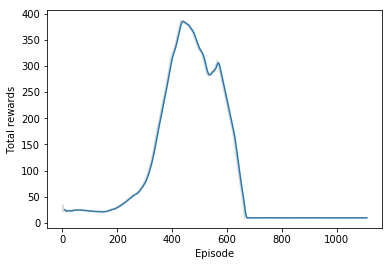

In [60]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

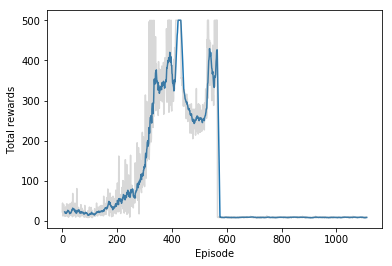

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

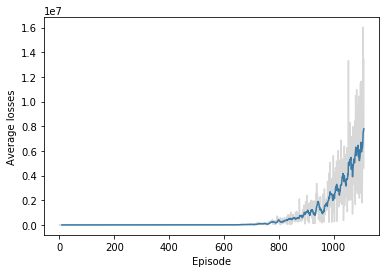

In [62]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.